In [1]:
import asdf
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
def get_abacus_cosmo():
    omega_b = 0.02237
    omega_cdm = 0.12
    h = 0.6736
    A_s = 2.083e-09
    n_s = 0.9649
    alpha_s = 0.0
    N_ur = 2.0328
    N_ncdm = 1.0
    omega_ncdm = 0.0006442
    w0_fld = -1.0
    wa_fld = 0.0
    cosmo = ccl.Cosmology(Omega_c=omega_cdm/h**2, Omega_b=omega_b/h**2, h=h, A_s=A_s, n_s=n_s, m_nu=0.06)
    cosmo.compute_linear_power()
    cosmo.compute_nonlin_power()
    return cosmo

In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [4]:
class AbacusFitter(object):
    def __init__(self, cosmo, z):
        self.z = z
        self.pks = {}
        data = asdf.open('AbacusData/power_mat_z%.3lf.asdf' % z)['data']
        self.ks = data['ks']
        self.pks['Pk_ICIC'] = np.load('AbacusData/Pk_ICIC.npy')
        self.pks['Pk_mm'] = data['Pk_mm']
        self.pks['Pk_mIC'] = data['Pk_mIC']
        data = asdf.open('AbacusData/power_red_z%.3lf.asdf' % z)['data']
        self.pks['Pk_redred'] = data['Pk_gg']
        self.pks['Pk_redm'] = data['Pk_gm']
        self.pks['Pk_redIC'] = data['Pk_gIC']
        data = asdf.open('AbacusData/power_all_z%.3lf.asdf' % z)['data']
        self.pks['Pk_allall'] = data['Pk_gg']
        self.pks['Pk_allm'] = data['Pk_gm']
        self.pks['Pk_allIC'] = data['Pk_gIC']

        # Theory spectra
        self.cosmo = cosmo

    def _eval_pk(self, pk, k, z=None):
        if z is None:
            z = self.z
        h = self.cosmo['h']
        return h**3*pk.eval(k*h, 1./(1+z), self.cosmo)

    def bk_model(self, k, b0, k0, alpha, c, k1):
        return b0*np.exp(-(k/k0)**alpha)*(1+c*np.exp(-((k-k1)/0.1)**2))

    def _fit_bias(self, tr, diagnostic_plot=False):
        # Compute bias
        bkd = self.pks[f'Pk_{tr}IC']/self.pks['Pk_ICIC']
        # Mean and error
        bk = np.mean(bkd.reshape([-1, 8]), axis=-1)
        ebk = np.std(bkd.reshape([-1, 8]), axis=-1)/np.sqrt(8)
        km = np.mean(self.ks.reshape([-1, 8]), axis=-1)
        # Fit model
        p, cov = curve_fit(self.bk_model, km, bk,
                           p0=(bk[0], 0.27, 2, 0, 0.2), sigma=ebk)

        if diagnostic_plot:
            print(p)
            bkfit = self.bk_model(self.ks, *p)
            plt.figure()
            plt.errorbar(km, bk, yerr=ebk, fmt='k.')
            plt.plot(self.ks, bkfit, 'r-')
            plt.xscale('log')
            plt.figure()
            plt.errorbar(km, (self.bk_model(km, *p)-bk)/ebk, yerr=np.ones_like(km), fmt='r.')
            plt.xscale('log')
        return p

    def _fit_ss(self, tr1, tr2=None, nn=True, diagnostic_plot=False):
        if tr2 is None:
            tr2 = tr1
        ck = (self.pks[f'Pk_{tr1}{tr2}'] -
              self.pks[f'Pk_{tr1}IC']*self.pks[f'Pk_{tr2}IC']/self.pks['Pk_ICIC'])
        # Smooth
        cks = savitzky_golay(ck, 25, 1)
        # Scale cut when this function reaches its maximum
        kcut = self.ks[np.argmax(cks)]
        if diagnostic_plot:
            print(kcut)
        # Low-k polynomial fit
        ilo = self.ks < kcut
        cklo_f = np.poly1d(np.polyfit(np.log(self.ks[ilo]), ck[ilo], 4, w=self.ks[ilo]**0.5))
        cklo = cklo_f(np.log(self.ks))
        # Combination
        ckfit = cklo*np.exp(-(self.ks/kcut)**5)+cks*(1-np.exp(-(self.ks/kcut)**5))
        # Null if needed
        if nn:
            # red-red z = 2
            ckfit[ckfit < 0] = 0
            ckfit[self.ks < 1E-2] = 0

        if diagnostic_plot:
            plt.figure(figsize=(15,10))
            plt.plot(self.ks, ck, 'k-', alpha=0.5)
            plt.plot(self.ks, cks, 'r-', lw=1)
            plt.plot(self.ks[ilo], cklo[ilo], 'b-')
            plt.plot(self.ks, ckfit, 'y--')
            plt.xscale('log')
        spline_ss = interp1d(np.log(self.ks), ckfit, fill_value='extrapolate', bounds_error=False)
        # Average slope in the last 50 points 
        der_hi = np.mean((np.diff(np.log(ckfit))/np.diff(np.log(self.ks)))[-100:])
        def ssfunc(k):
            kk = np.atleast_1d(k)
            lk = np.log(kk)
            # Interpolate
            r = spline_ss(lk)
            # Null at low k
            r[kk < self.ks[0]] = 0
            # Power-law at high-k
            id_hi = kk > self.ks[-1]
            r[id_hi] = ckfit[-1]*(kk[id_hi]/self.ks[-1])**der_hi
            if np.ndim(k) == 0:
                return r.flatten()
            else:
                return r
        return ssfunc

    def get_pk_fit(self, tr1, tr2, diagnostic_plot=False, nn_ss=True):
        pb1 = self._fit_bias(tr1, diagnostic_plot=diagnostic_plot)
        if tr1 == tr2:
            pb2 = pb1
        else:
            pb2 = self._fit_bias(tr2, diagnostic_plot=diagnostic_plot)
        ss = self._fit_ss(tr1, tr2, nn=nn_ss, diagnostic_plot=diagnostic_plot)

        def pkfit(k):
            b1 = self.bk_model(k, *pb1)
            b2 = self.bk_model(k, *pb2)
            pIC = self._eval_pk(self.cosmo._pk_lin['delta_matter:delta_matter'], k, z=99)
            ssk = ss(k)
            return b1*b2*pIC+ssk

        if diagnostic_plot:
            pk = self.pks[f'Pk_{tr1}{tr2}']
            pkf = pkfit(self.ks)
            plt.figure()
            plt.plot(self.ks, pk, 'k-')
            plt.plot(self.ks, pkf, 'r-')
            plt.loglog()
            plt.figure()
            plt.plot(self.ks, pk/pkf-1, 'k-')
            plt.xscale('log')
            plt.ylim([-0.2, 0.2])
        return pkfit


In [5]:
cosmo = get_abacus_cosmo()
zs_abacus = np.array([0., 0.1, 0.3, 0.5, 0.8, 1.1, 1.4, 1.7, 2.0, 2.5, 3.0])
zs_abacus_fake0 = zs_abacus.copy()
zs_abacus_fake0[0] = 0.1

/home/damonge/.local/lib/python3.8/site-packages/pyccl-2.2.1.dev68+g6a30bd45-py3.8.egg/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


In [6]:
fitters = [AbacusFitter(cosmo, z) for z in zs_abacus_fake0]

In [7]:
def get_pk2d_abacus():
    h = cosmo['h']
    k_s = np.geomspace(1E-4, 1E2, 512)
    lk_s = np.log(k_s)
    a_s = 1./(1+zs_abacus[::-1])
    tr_combs = [('m', 'm'),
                ('red', 'red'),
                ('red', 'm'),
                ('all', 'all'),
                ('all', 'm')]
    pks = {}
    for t1, t2 in tr_combs:
        pks[f'{t1}_{t2}'] = np.array([f.get_pk_fit(t1, t2)(k_s/h)/h**3
                                      for f in fitters[::-1]])
    pks_ccl = np.array([ccl.nonlin_matter_power(cosmo, k_s, a)
                        for a in a_s])
    ratio = pks_ccl / pks['m_m']
    return a_s, k_s, pks, pks_ccl, ratio

In [8]:
a_s, k_s, pks, pks_ccl, ratio = get_pk2d_abacus()
np.savez('AbacusData/pk2d_abacus.npz', a_s=a_s, k_s=k_s, pk_ccl=pks_ccl, **pks)

<ipython-input-4-863f36da4d17>:86: RuntimeWarning: divide by zero encountered in log
  der_hi = np.mean((np.diff(np.log(ckfit))/np.diff(np.log(self.ks)))[-100:])
/home/damonge/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/damonge/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


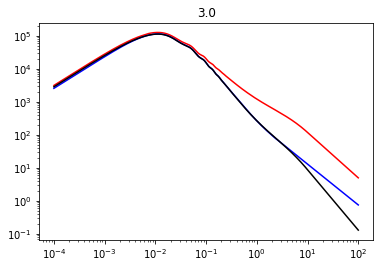

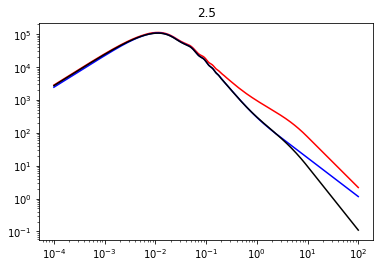

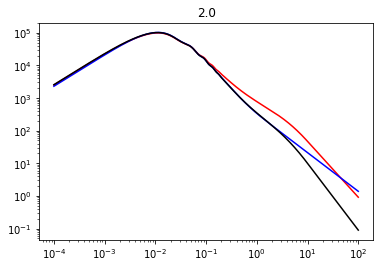

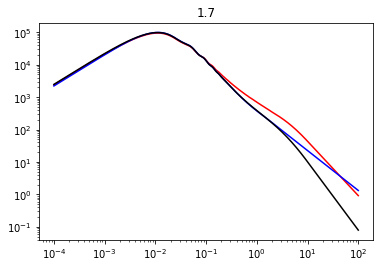

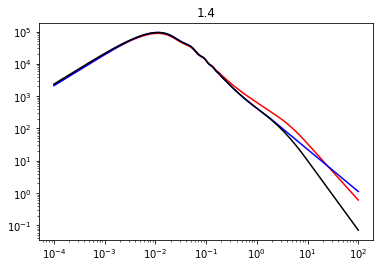

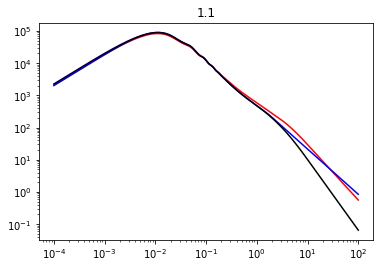

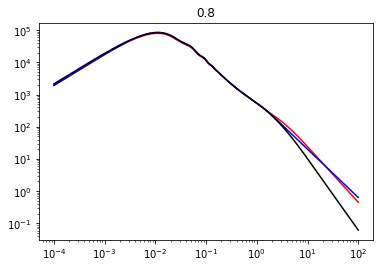

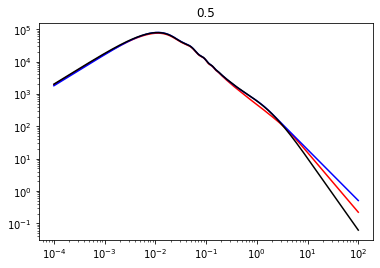

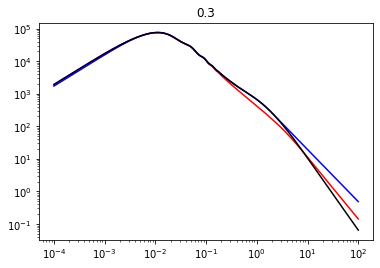

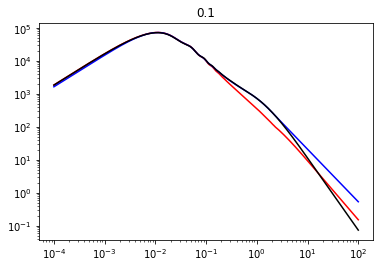

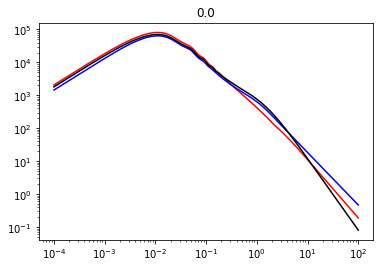

In [17]:
k_s = np.geomspace(1E-4, 1E2, 512)
for iz, z in enumerate(zs_abacus[::-1]):
    bz = 0.95/ccl.growth_factor(cosmo, 1./(1+z))**1.2
    plt.figure()
    plt.title(f'{z}')
    plt.plot(k_s, pks['all_all'][iz]*ratio[iz], 'r-')
    plt.plot(k_s, bz**2*pks['m_m'][iz], 'b-')
    plt.plot(k_s, bz**2*pks_ccl[iz], 'k-')
    plt.loglog()
    #plt.plot(k_s, ratio[iz]-1)
    #plt.xscale('log')
    #plt.ylim([-0.2, 0.2])
plt.show()